In [1]:
import numpy as np
import pandas as pd
#import pandas_datareader.data as web
import yfinance as yf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9,6)
import scipy.optimize as scpopt
import scipy.interpolate as sci
import seaborn as sns
plt.style.use('fivethirtyeight')


In [2]:
### define a taxa livre de risco
selic=10.5
taxa_livre_risco_ad=(1+selic/100) ** (1/252) - 1

## para uma dada carteira computa retorno, risco e IS anualizados
def estatisticas_portifolio(pesos,retornos):
        m = np.sum(retornos.mean()*pesos)
        s= np.sqrt(np.dot(pesos.T,np.dot(retornos.cov(),pesos)))
        sharpe = np.sqrt(252) * (m - taxa_livre_risco_ad) / s
        return np.array([m * 252, s * np.sqrt(252) , sharpe])

## função a ser maximizada, maior IS
def max_sharpe(pesos,retornos):
        return -estatisticas_portifolio(pesos,retornos)[2]

## função a ser minimizada, menor volatilidade
def min_volatilidade(pesos,retornos):
        return estatisticas_portifolio(pesos,retornos)[1]

# função a ser maximizada, maior volatilidade
def max_volatilidade(pesos,retornos):
        return -estatisticas_portifolio(pesos,retornos)[1]

## função a ser maximizada, maior retorno
def max_retorno(pesos,retornos):
        return -estatisticas_portifolio(pesos,retornos)[0]

## minimiza uma função usando um método de Programação Quadrática Sequencial, SLSQP
def otimizacao_funcao(func, retornos , restricoes = ({'type':'eq','fun': lambda x: np.sum(x)-1})): 
                             
                                  
        intervalo = tuple((0.0,1.0) for x in range(len(retornos.columns)))
        
        r=len(retornos.columns)
        init = np.array(r * [1. / r,])
        optimum=scpopt.minimize(func,
                                init,
                                args=retornos,
                                method='SLSQP',
                                bounds=intervalo,
                                constraints=restricoes)
        return optimum

## simulação de Monte Carlo para os problemas de otimização
def Monte_Carlo(retornos,  n=10**4):
        peso =  [] # lista dos pesos de cada uma das n carteira
        media=  [] # lista dos retornos das n carteiras
        dpadr=  [] # lista dos riscos das n carteiras
        r = len(retornos.columns)
        for i in range(n):
                w = np.random.random(r)
                w /= np.sum(w)
                RetorVolat = estatisticas_portifolio(w,retornos)
                peso.append(w)
                media.append(RetorVolat[0])
                dpadr.append(RetorVolat[1])
        peso  = np.array(peso)
        media = np.array(media)
        dpadr = np.array(dpadr)
        return peso, media, dpadr

## calcula os pontos (x,y) da fronteira eficiente
def fronteira(retornos):
        maxret =  otimizacao_funcao(max_retorno,retornos)
        retor_y = np.linspace(0,-maxret['fun'],100)
        volat_x = []
        bounds = tuple((0.0,1.0) for x in range(len(retornos.columns)))
        init = len(retornos.columns) * [1./len(retornos.columns),]
        restricoes = ({'type':'eq', 'fun': lambda x: np.sum(x)-1},
                      {'type':'eq', 'fun': lambda x: estatisticas_portifolio(x,retornos)[0] - retor})
        for retor in retor_y:
                optimum = otimizacao_funcao(min_volatilidade,retornos,restricoes)  
                volat_x.append(optimum['fun'])
        volat_x = np.array(volat_x)
        ind  = 0
        while round(volat_x[ind+1],8) == round(volat_x[ind],8): ind = ind +1
        return volat_x[ind:] , retor_y[ind:]

In [3]:
acoes = [  'ODPV3' , 'TASA4' , 'KEPL3' , # quality factor
            'EMBR3' , 'POMO4' , 'JSLG3' , # momnetum 
            'GOAU4' , 'PETR4' , 'LIGT3' , # value
            'EVEN3' , 'SLCE3' , 'MDIA3' ]  # growth

acoes.sort()

### dados históricos
dados = yf.download([x+'.SA' for x in acoes], period='2y',auto_adjust=True)['Close']
dados = dados.dropna()
dados.columns = acoes
retornos = dados.pct_change().dropna()

[*********************100%%**********************]  12 of 12 completed


<Figure size 500x500 with 0 Axes>

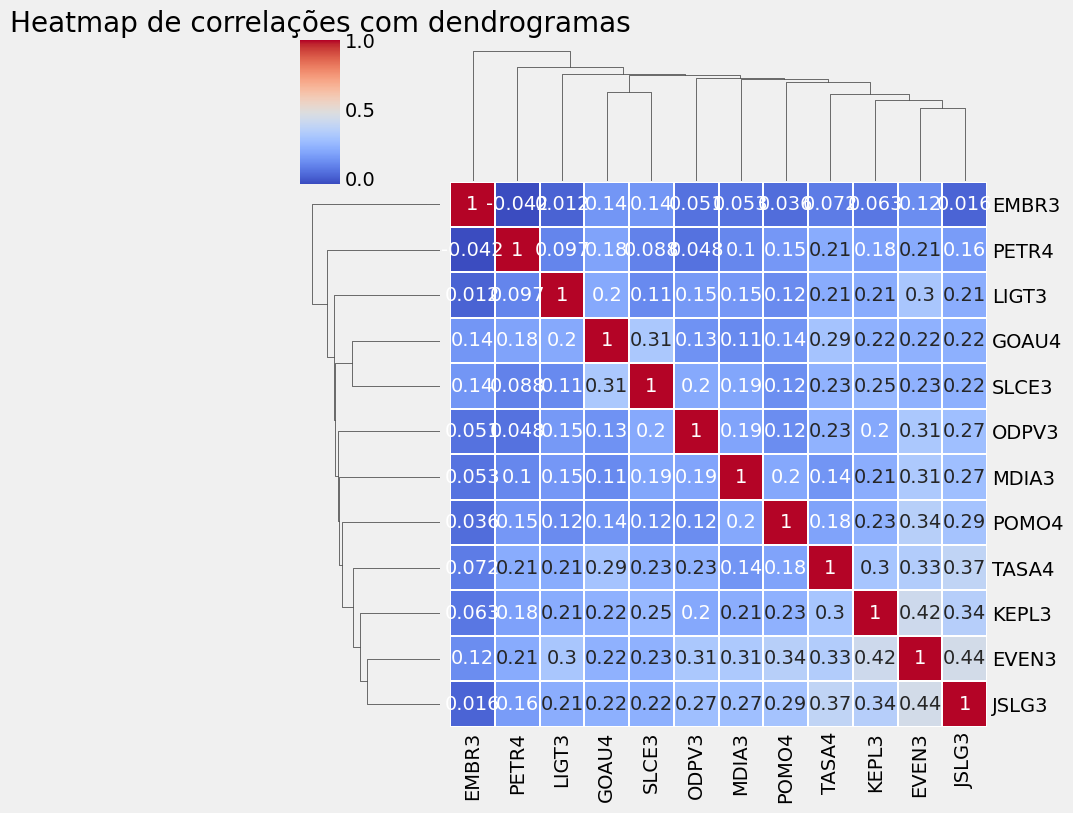

In [4]:
plt.figure(figsize=(5,5))
sns.clustermap(retornos.corr(), method='average', metric='euclidean', cmap='coolwarm', linewidths=0.1,
               figsize=(8,8), row_cluster=True, col_cluster=True ,annot=True)
plt.title('Heatmap de correlações com dendrogramas')
plt.show();

---------------------------------------------------------------
--- heuristica: alocação de maior índice de sharpe ------------
[('EMBR3', 0.24434), ('EVEN3', 0.01269), ('GOAU4', 0.01197), ('JSLG3', 0.11349), ('KEPL3', 0.0047), ('LIGT3', 0.00699), ('MDIA3', 0.00887), ('ODPV3', 0.14403), ('PETR4', 0.21407), ('POMO4', 0.18182), ('SLCE3', 0.04597), ('TASA4', 0.01105)]
Retorno esperado       0.4609
Volatilidade           0.1889
Índice de Sharpe       1.884
---------------------------------------------------------------
--- heuristica: alocação de menor risco -----------------------
[('EMBR3', 0.12814), ('EVEN3', 0.00359), ('GOAU4', 0.05539), ('JSLG3', 0.01858), ('KEPL3', 0.0569), ('LIGT3', 0.01949), ('MDIA3', 0.09391), ('ODPV3', 0.06389), ('PETR4', 0.14609), ('POMO4', 0.04533), ('SLCE3', 0.23796), ('TASA4', 0.13071)]
Retorno esperado       0.1934
Volatilidade           0.1663
Índice de Sharpe       0.531


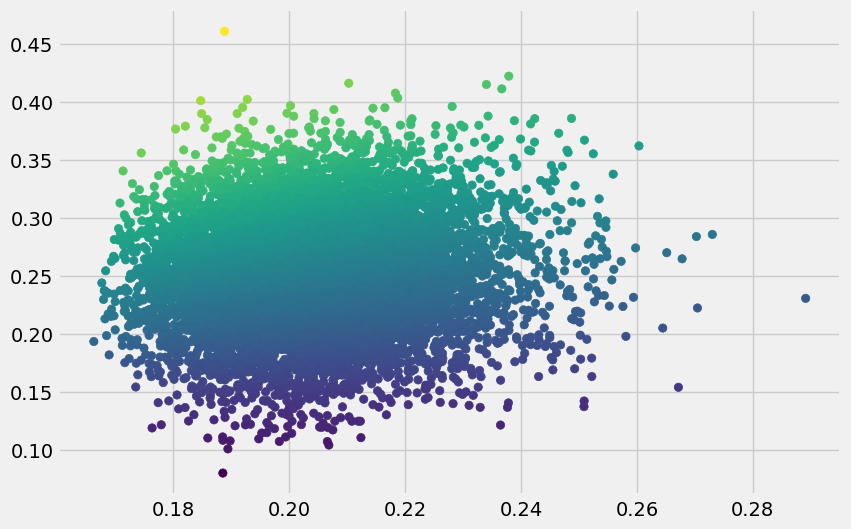

In [5]:
#########################################################################
### SIMULACAO Monte-Carlo
## heuristica otimização melhor indice sharpe e menor risco
pesos, medias, desvios = Monte_Carlo(retornos, 10000)
sharpe  = (medias - selic/100)/desvios
print('---------------------------------------------------------------')
print('--- heuristica: alocação de maior índice de sharpe ------------')
#### indice do max sharpe na simulação
ind_max_s = sharpe.argmax()
print(list(zip(acoes,list(pesos[ind_max_s].round(5)))))
print('Retorno esperado      ' , round(medias[ind_max_s],4))
print('Volatilidade          ' , round(desvios[ind_max_s],4))
print('Índice de Sharpe      ' , round(sharpe[ind_max_s],3))
print('---------------------------------------------------------------')
print('--- heuristica: alocação de menor risco -----------------------')
#### indice de min volatilidade na simulação
ind_min_s = desvios.argmin()
print(list(zip(acoes,list(pesos[ind_min_s].round(5)))))
print('Retorno esperado      ' , round(medias[ind_min_s],4))
print('Volatilidade          ' , round(desvios[ind_min_s],4))
print('Índice de Sharpe      ' , round(sharpe[ind_min_s],3))
### gráfico
plt.figure(2)
plt.scatter(desvios,medias,c=sharpe)
#       plt.scatter(desvios[ind_max_s] , medias[ind_max_s] , c='red', marker='s', s=50)
#       plt.scatter(desvios[ind_min_s] , medias[ind_min_s] , c='blue', marker='s', s=50)

In [6]:
#########################################################################
##### OTIMIZACAO - max Sharpe
optimum_s=otimizacao_funcao(max_sharpe, retornos)
print('----------------------------------------------------------------')
print('--- otimização: distribuição dos pesos com IS ótimo ------------')
print(list(zip(acoes,list(optimum_s['x'].round(5)))))
medias_opt = np.sum(retornos.mean()*252*optimum_s['x'])
desvios_opt= np.sqrt(np.dot(optimum_s['x'].T,np.dot(retornos.cov()*252,optimum_s['x'])))
sharpe_opt = (medias_opt - selic/100)/desvios_opt
print('Retorno esperado ' , round(medias_opt,5))
print('Volatilidade     ' , round(desvios_opt,5))
print('Indice de Sharpe ' , round(sharpe_opt,5))
#####
##### OTIMIZACAO - min variancia
#####
optimum_v=otimizacao_funcao(min_volatilidade , retornos)
print('----------------------------------------------------------------')
print('---  otimização: distribuição com menor volatilidade -----------')
print(list(zip(acoes,list(optimum_v['x'].round(5)))))
medias_vol = np.sum(retornos.mean()*252*optimum_v['x'])
desvios_vol= np.sqrt(np.dot(optimum_v['x'].T,np.dot(252*retornos.cov(),optimum_v['x'])))
sharpe_vol = (medias_vol -  selic/100)/desvios_vol
print('Retorno esperado ' , round(medias_vol,5))
print('Volatilidade     ' , round(desvios_vol,5))
print('Indice de Sharpe ' , round(sharpe_vol,5))
### gráfico
# plt.figure(2);
#       plt.scatter(desvios_opt, medias_opt, c='blue', marker='*', s=190)  # estrela vermelho
#       plt.scatter(desvios_vol, medias_vol, c='blue', marker='*', s=190) # estrela azul

----------------------------------------------------------------
--- otimização: distribuição dos pesos com IS ótimo ------------
[('EMBR3', 0.4331), ('EVEN3', 0.0), ('GOAU4', 0.0), ('JSLG3', 0.01157), ('KEPL3', 0.0), ('LIGT3', 0.02787), ('MDIA3', 0.0), ('ODPV3', 0.0), ('PETR4', 0.18365), ('POMO4', 0.3438), ('SLCE3', 0.0), ('TASA4', 0.0)]
Retorno esperado  0.64526
Volatilidade      0.23372
Indice de Sharpe  2.31161
----------------------------------------------------------------
---  otimização: distribuição com menor volatilidade -----------
[('EMBR3', 0.13258), ('EVEN3', 0.0), ('GOAU4', 0.15285), ('JSLG3', 0.0), ('KEPL3', 0.04165), ('LIGT3', 0.0), ('MDIA3', 0.09863), ('ODPV3', 0.12492), ('PETR4', 0.14847), ('POMO4', 0.06444), ('SLCE3', 0.19609), ('TASA4', 0.04036)]
Retorno esperado  0.2294
Volatilidade      0.15992
Indice de Sharpe  0.77791
